# Import needed modules

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [2]:
import os
import pandas as pd

benign_dir = r'C:\Users\Deeksha\Desktop\mini project\lung_colon_image_set\colon_image_sets\benign'
malignant_dir = r'C:\Users\Deeksha\Desktop\mini project\lung_colon_image_set\colon_image_sets\malig'
img_height, img_width = 224, 224
batch_size = 16

# Function to load images and labels from directories
def load_data(directory, label):
    images = []
    labels = []
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)
        images.append(image_path)
        labels.append(label)
    return images, labels

# Load images and labels from both directories
benign_images, benign_labels = load_data(benign_dir, label=0)
malignant_images, malignant_labels = load_data(malignant_dir, label=1)

# Combine images and labels
images = benign_images + malignant_images
labels = benign_labels + malignant_labels

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(images, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)



In [3]:
df

filepaths  labels
0     C:\Users\Deeksha\Desktop\mini project\lung_col...       0
1     C:\Users\Deeksha\Desktop\mini project\lung_col...       0
2     C:\Users\Deeksha\Desktop\mini project\lung_col...       0
3     C:\Users\Deeksha\Desktop\mini project\lung_col...       0
4     C:\Users\Deeksha\Desktop\mini project\lung_col...       0
...                                                 ...     ...
9995  C:\Users\Deeksha\Desktop\mini project\lung_col...       1
9996  C:\Users\Deeksha\Desktop\mini project\lung_col...       1
9997  C:\Users\Deeksha\Desktop\mini project\lung_col...       1
9998  C:\Users\Deeksha\Desktop\mini project\lung_col...       1
9999  C:\Users\Deeksha\Desktop\mini project\lung_col...       1

[10000 rows x 2 columns]

### **Split dataframe into train, valid, and test**

In [4]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Create image data generator**

In [5]:
batch_size =16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
# Assuming 'labels' column in your DataFrame contains integer class indices
train_df['labels'] = train_df['labels'].astype(str)
valid_df['labels'] = valid_df['labels'].astype(str)
test_df['labels'] = test_df['labels'].astype(str)

# Then continue with the flow_from_dataframe function calls
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 8000 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


### **Show sample from train data**

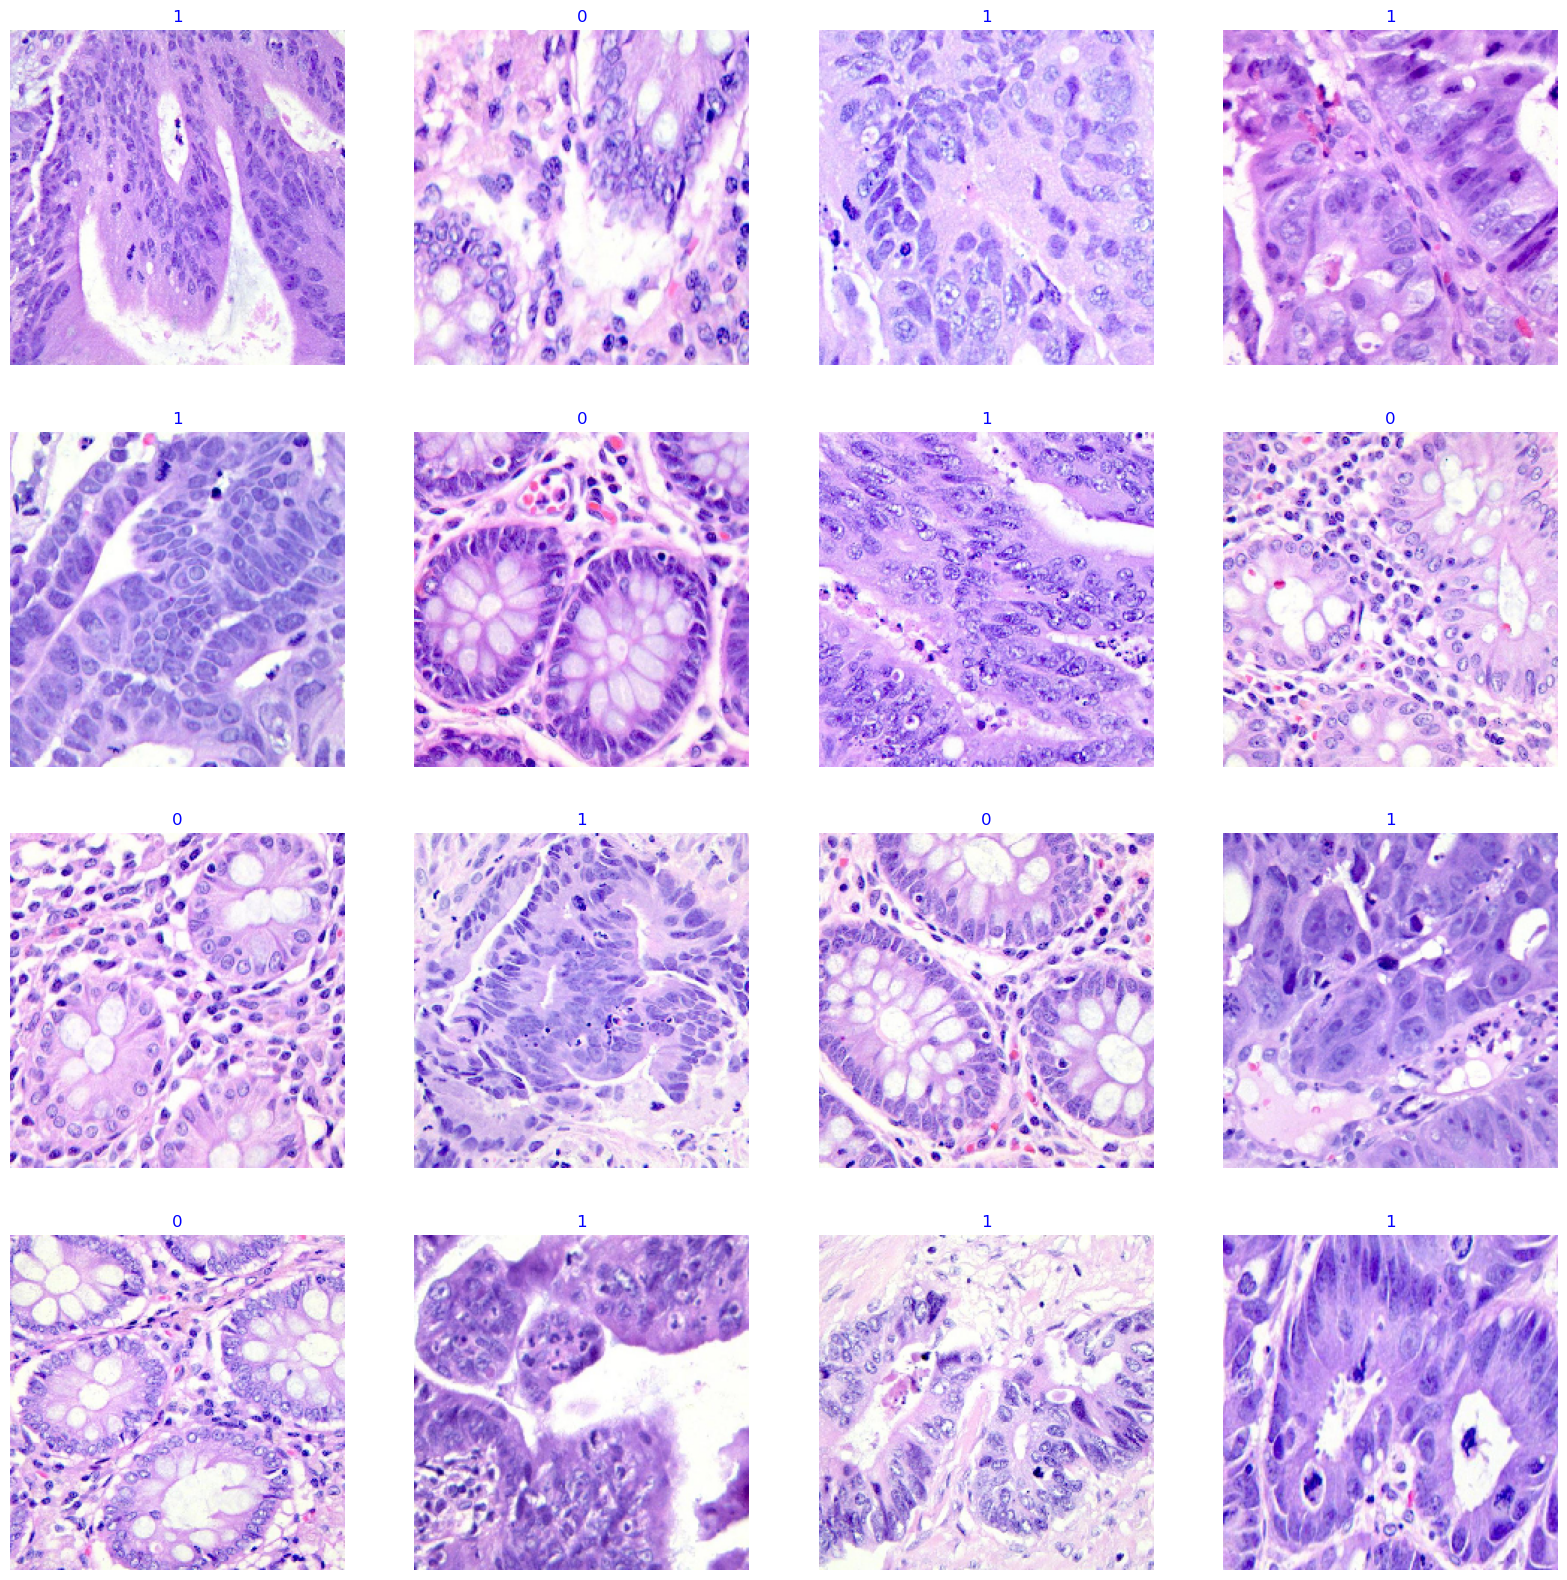

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB4(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

71686520/71686520 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 batch_normalization (BatchN  (None, 1792)             7168      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               459008    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 18,140,513
Trainable params: 18,011,722
Non

#### **Train model**

In [9]:
epochs =8  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/8
500/500 [==============================] - 169s 298ms/step - loss: 3.2379 - accuracy: 0.9812 - val_loss: 1.2875 - val_accuracy: 1.0000
Epoch 2/8
500/500 [==============================] - 141s 282ms/step - loss: 0.7547 - accuracy: 0.9969 - val_loss: 0.3820 - val_accuracy: 1.0000
Epoch 3/8
500/500 [==============================] - 141s 282ms/step - loss: 0.2674 - accuracy: 0.9980 - val_loss: 0.1581 - val_accuracy: 1.0000
Epoch 4/8
500/500 [==============================] - 141s 283ms/step - loss: 0.1345 - accuracy: 0.9998 - val_loss: 0.0929 - val_accuracy: 1.0000
Epoch 5/8
500/500 [==============================] - 141s 281ms/step - loss: 0.0980 - accuracy: 0.9991 - val_loss: 0.0737 - val_accuracy: 1.0000
Epoch 6/8
500/500 [==============================] - 142s 283ms/step - loss: 0.0804 - accuracy: 0.9999 - val_loss: 0.0602 - val_accuracy: 1.0000
Epoch 7/8
500/500 [==============================] - 141s 282ms/step - loss: 0.0727 - accuracy: 0.9990 - val_loss: 0.0567 - val_ac

#### **Display model performance**

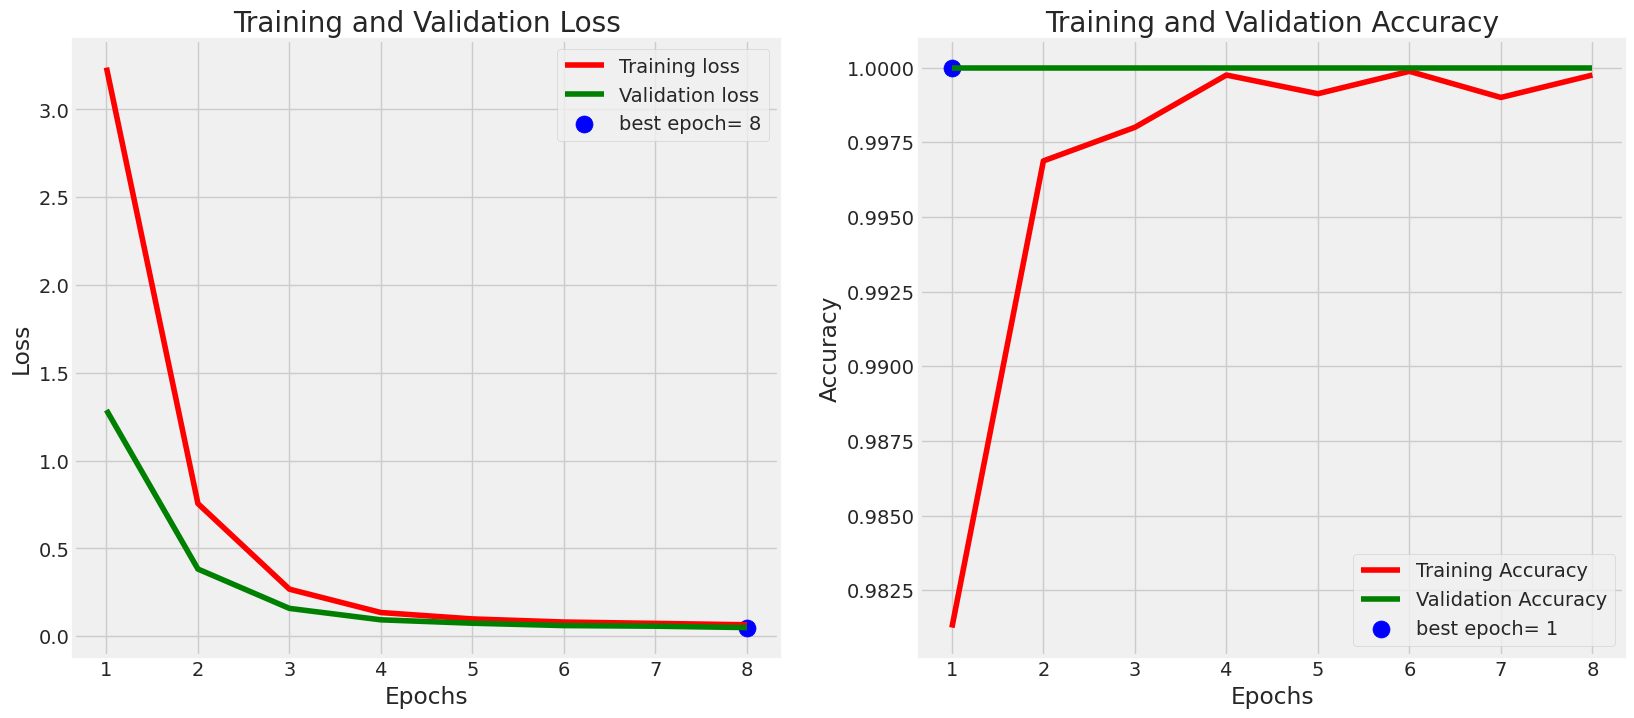

In [10]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

# **Get Predictions**

In [12]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

Confusion Matrix
[[409   1]
 [  3 387]]


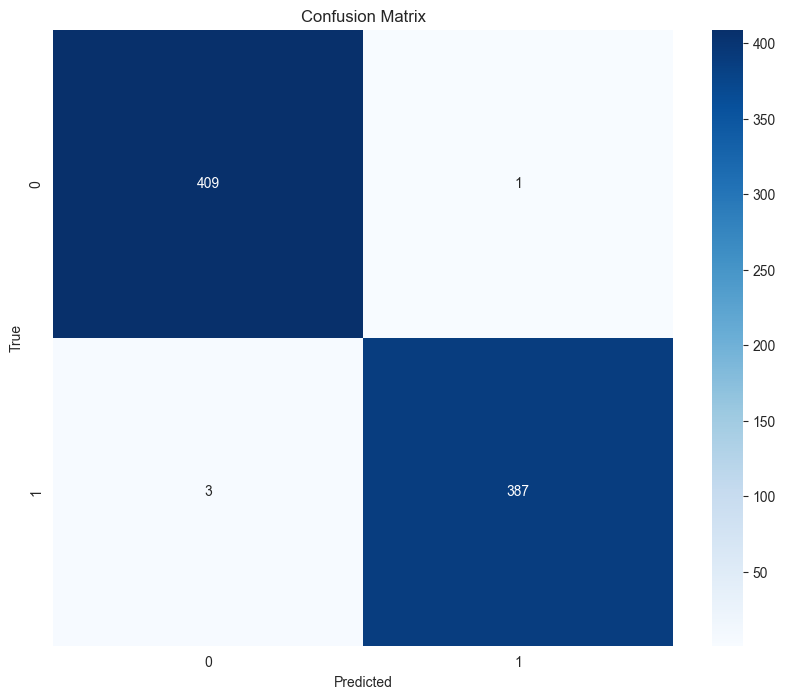

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       410
           1       1.00      0.99      0.99       390

    accuracy                           0.99       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      0.99      0.99       800

Accuracy: 99.50%


In [39]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the .h5 model
model = load_model('work.h5')

# Compile the model with appropriate metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Generate predictions
y_pred = model.predict(test_gen, steps=len(test_gen), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys())
print("Classification Report")
print(report)


#### **Save model**

In [15]:
#Save the model
model.save('Colon Cancer.h5')

Prediction using model

Resizing image to [224 224   3]


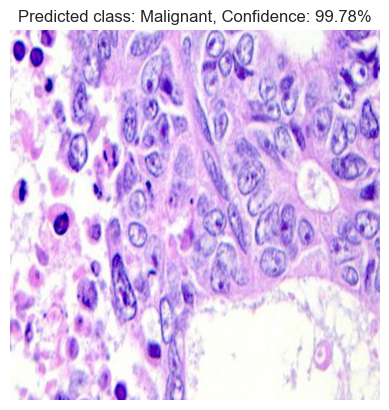

In [41]:
import tensorflow as tf
from PIL import Image

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=r'C:\Users\Deeksha\Desktop\mini project\last.tflite')  # Specify the path to your TFLite model
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the image
image_path = r'C:\Users\Deeksha\Desktop\mini project\lung_colon_image_set\colon_image_sets\malig\colonca24.jpeg'
image = Image.open(image_path)
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Check the input shape expected by the model
input_shape = input_details[0]['shape']
if img_array.shape != tuple(input_shape[1:]):
    print(f"Resizing image to {input_shape[1:]}")
    img_array = tf.image.resize(img_array, input_shape[1:3])

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)

# Perform inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get the predicted class and confidence score
class_labels = ['Benign', 'Malignant']
predicted_class_index = np.argmax(output_data[0])
predicted_class = class_labels[predicted_class_index]
confidence = output_data[0][predicted_class_index] * 100

# Display the image with the predicted class and confidence score
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}%")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted class: ('n07747607', 'orange', 0.10482659)


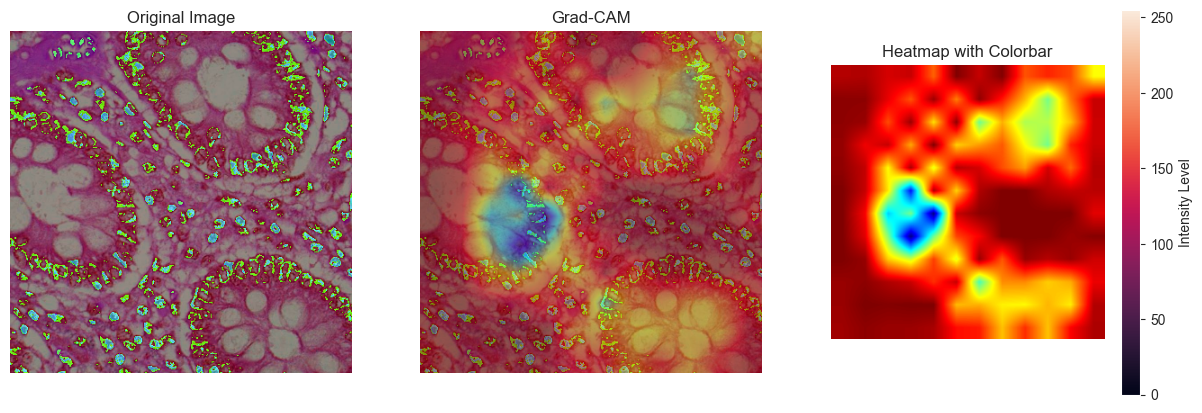

In [6]:
import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input

def get_grad_cam(model, img_array, class_index):
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer('top_activation').output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_output = preds[:, class_index]

    grads = tape.gradient(class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Load the pre-trained EfficientNetB4 model
model = EfficientNetB4(weights='imagenet')

# Define input shape for EfficientNetB4
img_size = (380, 380)  # Updated input shape
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Load and preprocess an image
img_path = r'C:\Users\Deeksha\Desktop\mini project\lung_colon_image_set\colon_image_sets\benign\colonn200.jpeg'
img = image.load_img(img_path, target_size=img_size)  # Resize the image to match the model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
preds = model.predict(img_array)
predicted_class_index = np.argmax(preds[0])
print('Predicted class:', decode_predictions(preds, top=1)[0][0])

# Generate Grad-CAM
heatmap = get_grad_cam(model, img_array, predicted_class_index)

# Resize the heatmap to match the image dimensions
heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))  # Use img_array shape here

# Scale the heatmap to the range 0 to 255
heatmap = (heatmap * 255).astype(np.uint8)

# Apply colormap for visualization
heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Blend the heatmap with the original image
superimposed_img = cv2.addWeighted(img_array[0].astype(np.uint8), 0.6, heatmap_colored, 0.4, 0)

# Plot the original image, the Grad-CAM, and the heatmap with colorbar
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_array[0].astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(superimposed_img.astype(np.uint8))
plt.title('Grad-CAM')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(heatmap_colored)
plt.colorbar(label='Intensity Level')
plt.title('Heatmap with Colorbar')
plt.axis('off')

plt.show()


In [64]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert() 

print("model converted")

# Save the model. 
with open('Colongradcam.tflite', 'wb') as f:
    f.write(tflite_model)

model converted
